# Climate Change Sonification
## Exploratory Data Analysis

In [1]:
import os, sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from netCDF4 import Dataset

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import animation 
from IPython.display import HTML, Image
from matplotlib import rcParams
rcParams["font.family"] = "Times New Roman"
rcParams["savefig.dpi"] = 300
# rcParams['animation.html'] = 'html5'

In [2]:
def process_data(frequency):
    PATH = f"data/{frequency}/"
    files = sorted([ f for f in os.listdir(path=PATH) if f.endswith(".nc4") ])
    print(len(files), "files to be read.")

    co2_data = []
    for f in tqdm(files):
        try:
            co2_data.append(Dataset(PATH + f).variables["XCO2"][:])
        except:
            pass
    print(len(files) - len(co2_data), "files could not be read.")
    print("Size:", sum([sys.getsizeof(d) for d in co2_data]), "bytes")

    return co2_data, files


def animate_co2(frequency="monthly", savepath=None):

    # set up plotting area
    fig, ax = plt.subplots()
    ax.tick_params(
        left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False
    )

    # colorbar
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cmap = mpl.cm.inferno
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = mpl.colorbar.ColorbarBase(
        cax, 
        cmap=cmap,
        norm=norm,
        orientation="vertical"
    )

    def plot_img(data):
        """Plot CO2 values"""
#         data = np.flip(data, axis=0)
        im = ax.pcolormesh(
            data,
            cmap=cmap, 
            vmin=vmin, 
            vmax=vmax,
            animated=True,
            rasterized=True
        )
        return im, 

    # for blitting (optimized raster image animation)
    im, = plot_img(co2_data[0][0,:,:])

    def update(i):  
        im, = plot_img(co2_data[i][0,:,:])

        # axis title
        if frequency == "daily":
            date = files[i].split("_")[4]
            ax.set_title(date[-2:] + " - " + date[-4:-2] + " - " + date[:-4])
        elif frequency == "monthly":
            date = files[i].split("_")[4]
            ax.set_title(date[-2:] + " - " + date[:-2])
        return im,

    # animate
    ani = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(files), 
        interval=500, 
        repeat=True, 
        repeat_delay=1000,
        blit=True 
    )

    # save and display
    plt.tight_layout()
    
    if savepath is not None:
        ani.save(savepath, writer="imagemagick")
    
    return ani

### Monthly Data

In [3]:
co2_data, files = process_data("monthly")
vmin = min([ d.min() for d in co2_data ])
vmax = max([ d.max() for d in co2_data ])

  0%|          | 0/82 [00:00<?, ?it/s]/Users/irisfolpmers/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
 12%|█▏        | 10/82 [00:00<00:00, 89.52it/s]

82 files to be read.


100%|██████████| 82/82 [00:00<00:00, 95.21it/s]

0 files could not be read.
Size: 14432 bytes


In [4]:
# Global statistics
means = np.array([ d.mean() for d in co2_data ])
stds = np.array([ d.std() for d in co2_data ])
mins = np.array([ d.min() for d in co2_data ])
maxs = np.array([ d.max() for d in co2_data ])

## Plot Iris

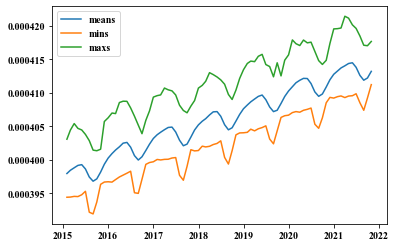

In [5]:
dates = np.array(pd.date_range(start='01/2015', end='11/2021', freq='M'))
plt.plot(dates, means, label="means")
# plt.plot(dates, stds, label="stds")
plt.plot(dates, mins, label="mins")
plt.plot(dates, maxs, label="maxs")
plt.legend()
plt.show()

## detrended means

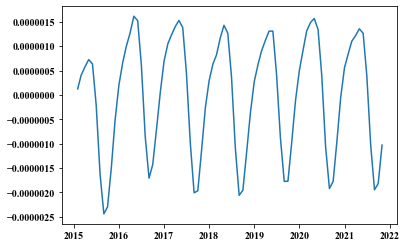

In [6]:
from scipy import signal
means_detrended = signal.detrend(means)
plt.plot(dates, means_detrended)
plt.show()

## Regions

In [7]:
co2_data_np = np.array(co2_data)
# print(co2_data_np.shape) # (82, 1, 361, 576)
shape = list(co2_data_np.shape)
first = shape[2]/4
second = 2*shape[2]/4
third = 3*shape[2]/4


first_part = co2_data_np[:, :, 0:int(shape[2]/2), 0:int(shape[3]/2)]
second_part = co2_data_np[:, :, int(shape[2]/2):, 0:int(shape[3]/2)]
third_part = co2_data_np[:, :, 0:int(shape[2]/2), int(shape[3]/2):]
fourth_part = co2_data_np[:, :, int(shape[2]/2):, int(shape[3]/2):]
upper_part = co2_data_np[:, :, 0:int(shape[2]/2), :]

In [8]:
def calculate_all(part):
    means = np.array([ d.mean() for d in part ])
    stds = np.array([ d.std() for d in part ])
    mins = np.array([ d.min() for d in part ])
    maxs = np.array([ d.max() for d in part ])
    return means, stds, mins, maxs

first_means, first_stds, first_mins, first_maxs = calculate_all(first_part)  
second_means, second_stds, second_mins, second_maxs = calculate_all(second_part)
third_means, third_stds, third_mins, third_maxs = calculate_all(third_part)
fourth_means, fourth_stds, fourth_mins, fourth_maxs = calculate_all(fourth_part)

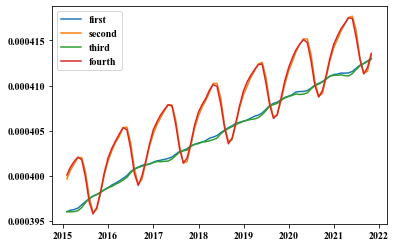

In [9]:
plt.plot(dates, first_means, label="first")
plt.plot(dates, second_means, label="second")
plt.plot(dates, third_means, label="third")
plt.plot(dates, fourth_means, label="fourth")
plt.legend()
plt.show()

## Derivatives

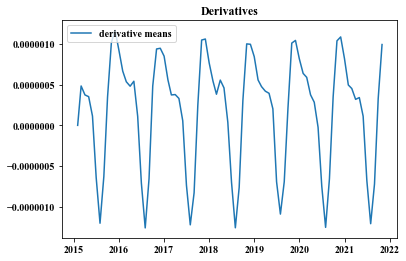

In [10]:
def der(means):
    deriv = [0]
    for i in range(len(means)-1):
        deriv.append(means[i+1]-means[i])
    return deriv


deriv_means = der(means)
deriv_std = der(stds)
deriv_min = der(mins)
deriv_max = der(maxs)
plt.plot(dates, deriv_means, label="derivative means")
# plt.plot(dates, deriv_std, label="derivative std")
# plt.plot(dates, deriv_min, label="derivative min")
# plt.plot(dates, deriv_max, label="derivative max")
plt.title("Derivatives")
plt.legend()
plt.show()

## Northern Hemisphere

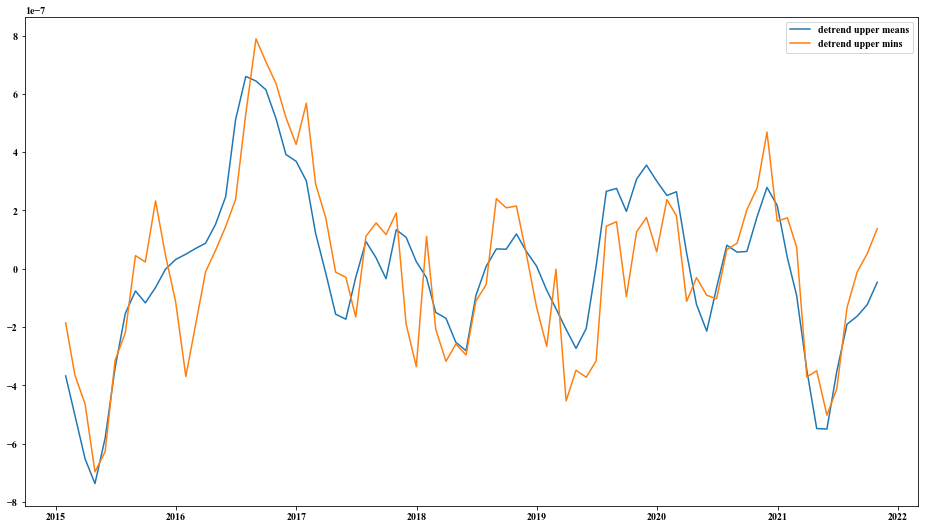

In [11]:
upper_means, upper_stds, upper_mins, upper_maxs = calculate_all(upper_part)  

# Upper means, stds, mins and maxs
_, ax5 = plt.subplots(figsize=(16,9))
# ax5.plot(dates, upper_means, label="upper means")
# # ax5.plot(dates, upper_means, label="upper stds")
# ax5.plot(dates, upper_mins, label="upper mins")
# ax5.plot(dates, upper_maxs, label="upper maxs")

# Derivatives of upper means, stds, mins and maxs
# ax5.plot(dates, der(upper_means), label="deriv upper means")
# ax5.plot(dates, der(upper_means), label="deriv upper stds")
# ax5.plot(dates, der(upper_mins), label="deriv upper mins")
# ax5.plot(dates, der(upper_maxs), label="deriv upper maxs")

# Detrended upper means, stds, mins and maxs
ax5.plot(dates, signal.detrend(upper_means), label="detrend upper means")
# ax5.plot(dates, signal.detrend(upper_means), label="detrend stds")
ax5.plot(dates, signal.detrend(upper_mins), label="detrend upper mins")
# ax5.plot(dates, signal.detrend(upper_maxs), label="detrend upper maxs")

plt.legend()
plt.show()

# Sonification

## Astronify

In [12]:
from astronify.series import SoniSeries
from astropy.table import Table

data_table = Table({"time": range(len(means)),
                    "flux": means})

data_soni = SoniSeries(data_table)
data_soni.note_spacing = 0.3
data_soni.sonify()
# data_soni.play()
# data_soni.write("astronify.wav")


WxPython is not found for the current python version.
Pyo will use a minimal GUI toolkit written with Tkinter (if available).
This toolkit has limited functionnalities and is no more
maintained or updated. If you want to use all of pyo's
GUI features, you should install WxPython, available here:
http://www.wxpython.org/



## Sonipy

In [13]:
from sonipy.sonify import SonifyTool

Tone = SonifyTool(range(len(means)), means)
# Tone.play()
# Tone.save()


multitones created


/Users/irisfolpmers/opt/anaconda3/lib/python3.7/site-packages/sonipy/thinkdsp.py:734: UserWarning: Can't add these waveforms; their time arrays don't line up.
  "Can't add these waveforms; their " "time arrays don't line up."


In [14]:
C4 = 161.6 # Hz
frequency_args = {
  'frequency_min' : C4,
  'frequency_max' : C4*4
  # 'cents_per_value' : -680,
  # 'value_min' : 0,
  # 'value_max' : 1,
}

duration_args = {
  'time_total' : 20000, # ms
  # 'time_min' : 100, # ms
  # 'time_max' : 800, # ms
}

duration_scale = 1. / 20000. # x value / time (ms)

Tone = SonifyTool(means, range(len(means)),
                  frequency_args = frequency_args,
                  duration_args = duration_args,
                  # duration_scale = duration_scale,
                  bliplength=1.1)

# Tone.play()
# Tone.save()

multitones created


### Daily (veeeery slow)

In [15]:
co2_data, files = process_data("daily")
vmin = min([ d.min() for d in co2_data ])
vmax = max([ d.max() for d in co2_data ])

  0%|          | 0/646 [00:00<?, ?it/s]/Users/irisfolpmers/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
  1%|          | 7/646 [00:00<00:10, 60.06it/s]

646 files to be read.


100%|██████████| 646/646 [00:10<00:00, 59.89it/s]


0 files could not be read.
Size: 113696 bytes


In [16]:
# Global statistics
means = np.array([ d.mean() for d in co2_data ])
stds = np.array([ d.std() for d in co2_data ])
mins = np.array([ d.min() for d in co2_data ])
maxs = np.array([ d.max() for d in co2_data ])

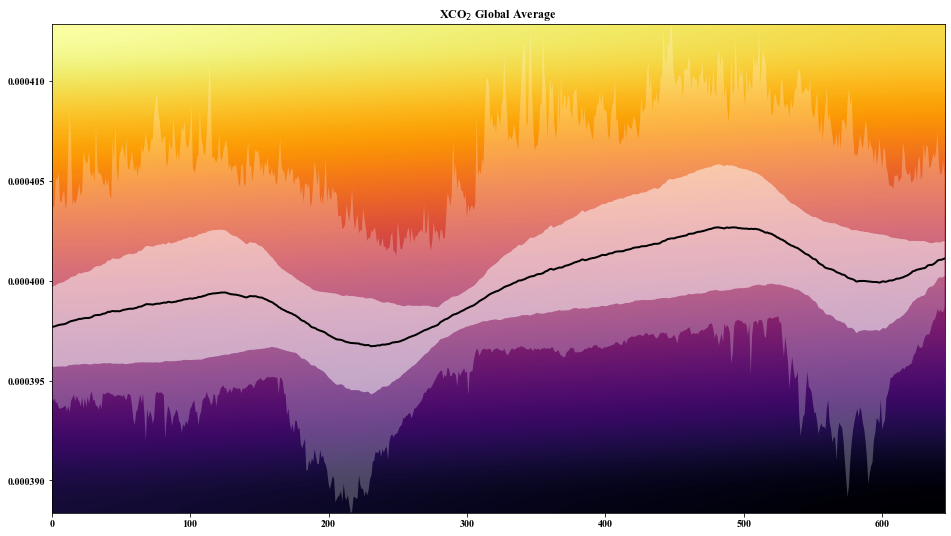

In [17]:
_, ax = plt.subplots(figsize=(16,9))

x = np.arange(len(co2_data))

xmin = x.min()
xmax = x.max()
ymin = mins.min()
ymax = maxs.max()

k = 10
X = np.arange(k * k).reshape(k,k)
ax.imshow(X, interpolation='bicubic', cmap=mpl.cm.inferno_r,
          extent=(xmin, xmax, ymin, ymax), alpha=1, aspect='auto')

ax.plot(means, lw=2, c="black")

# standard deviations
ax.fill_between(x, means, means + stds, facecolor="white", alpha=.5)
ax.fill_between(x, means, means - stds, facecolor="white", alpha=.5)

# extrema
ax.fill_between(x, means, mins, facecolor="white", alpha=.25)
ax.fill_between(x, means, maxs, facecolor="white", alpha=.25)

ax.set_ylim(ymin, ymax)
ax.set_title("XCO$_2$ Global Average")
plt.savefig("daily_global_average.png")
plt.show()

# Iris

In [18]:
print(np.array(co2_data).shape)

(646, 1, 361, 576)
